*   Nama: Theophilus Nathan Tanudjaja
*   NIM: 2502007514

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer

from transformers import TFDistilBertModel, DistilBertTokenizer

from keras.layers import Dense,Dropout, Input
from keras import regularizers
from sklearn.metrics import classification_report

In [ ]:
!pip install gdown==v4.6.3

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
!gdown "1RqzN9rndkPETeDUWv7PzieW_UuK7a6vV&confirm=t"
!unzip DatasetUAS.zip

Downloading...
From: https://drive.google.com/uc?id=1RqzN9rndkPETeDUWv7PzieW_UuK7a6vV&confirm=t
To: /content/DatasetUAS.zip
100% 803k/803k [00:00<00:00, 7.12MB/s]
Archive:  DatasetUAS.zip
  inflating: Emotion.csv             
  inflating: X.csv                   


In [ ]:
df = pd.read_csv('Emotion.csv')

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<Axes: xlabel='count', ylabel='label'>

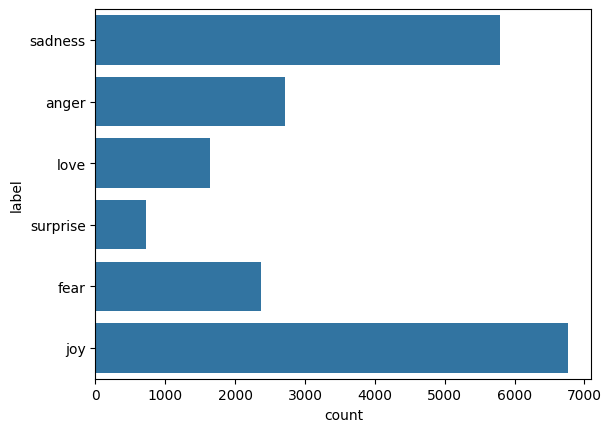

In [ ]:
#cek balance dari Y
sns.countplot(df['label'])

dari hasil countplot ini kita bisa tahu bahwa Y tidak balance maka dari itu, lebih baik menggunakan f1 score dibandingkan akurasi saat evaluasi matriks

#preprocessing

In [ ]:
#cek null value
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
df.duplicated().sum()

1

In [ ]:
#menghapus duplicate value
index = df[df.duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [ ]:
#cek duplicate dari df['text] tapi punya label yang berbeda
df[df['text'].duplicated() == True].head()

,text,label
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise


In [ ]:
#contoh
df[df['text'] == df.iloc[5067]['text']]

,text,label
1501,i feel on the verge of tears from weariness i ...,love
5067,i feel on the verge of tears from weariness i ...,joy


In [ ]:
#menhapus duplicate dari df['text']
df_clean = df.copy()
index = df_clean[df_clean['text'].duplicated() == True].index
df_clean.drop(index, axis = 0, inplace = True)
df_clean.reset_index(inplace=True, drop = True)

In [ ]:
#label encoder
df_clean['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
df_new = df_clean.copy()
list = {
    "sadness": 0,
    "anger":1,
    "love": 2,
    "surprise": 3,
    "fear": 4,
    "joy": 5
}
df_new["label"] = df_new["label"].map(list)
df_new['label'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
import re
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#function for cleaning
def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " " .join(text)

def Remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stopwords.words("english")]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def cleaning_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : Remove_stop_words(text))
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

In [ ]:
df_final = cleaning_text(df_new)

In [ ]:
print("Before: ", df['text'][1])
print("After : ", df_final['text'][1])

Before:  i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
After :  go feeling hopeless damned hopeful around someone care awake


In [ ]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
max_len=32
text=df_final['text']
labels=df_final['label']
len(text),len(labels)

(19948, 19948)

In [ ]:
input_ids=[]
attention_masks=[]

for sent in text:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1a.
- memastikan tidak ada null value dan duplicate
- lebel encoder:
mengganti value y menjadi 0-5 agar dapat di proses oleh model.
- lower case: mengganti semua upper case menjadi lower case
- Remove stop words: menghilangkan semua stop word seperti 'is' atau 'a'
- remove number: menghilangkan angka
- remove punctuations: menghilangkan semua punctuation seperti titik, koma, dash, dll
- remove extra whitespace: menhilangkan spasi yang lebih dari 1
- remove url: menghilngkan text url
- lemmatization: metode yang lebih baik dan akurat dibandingkan stemming untuk mereduksi kata menjadi "root form"nya atau kata awalnya
- tokenizing: mentokenizasi menggunakan pretrain model agar dapat kita masukin ke model distilBERT langsung.

mungkin ada beberapa langkah preprocessing yang tidak perlu dalam kasus ini seperti lower case, karena jika dilihat dari .head() tidak ada uppercase.
namun untuk berjaga-jaga jika ditengah-tengah data ada yang upper case.


#model

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.3)
val_inp,test_inp,val_label,test_label,val_mask,test_mask=train_test_split(val_inp,val_label,val_mask,test_size=0.5)

print('Train inp shape {} Val input shape {} Test inp shape {}\nTrain label shape {} Val label shape {} Test label Shape{}\nTrain attention mask shape {} Val attention mask shape {} Test label shape{}'.format(train_inp.shape,val_inp.shape,test_inp.shape,train_label.shape,val_label.shape,test_label.shape,train_mask.shape,val_mask.shape, test_mask.shape))

Train inp shape (13963, 32) Val input shape (2992, 32) Test inp shape (2993, 32)
Train label shape (13963,) Val label shape (2992,) Test label Shape(2993,)
Train attention mask shape (13963, 32) Val attention mask shape (2992, 32) Test label shape(2993, 32)


2b. Data splitting menggunakan train_test_split menjadi 70% trainning, 15% validating, dan 15% testing

In [ ]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(6, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [ ]:
model=create_model()

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [ ]:
history=model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=5,validation_data=([val_inp,val_mask],val_label))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


437/437 [==============================] - 98s 173ms/step - loss: 5.5714 - accuracy: 0.8275 - val_loss: 4.2512 - val_accuracy: 0.9335
Epoch 2/5
437/437 [==============================] - 60s 137ms/step - loss: 3.4483 - accuracy: 0.9398 - val_loss: 2.7535 - val_accuracy: 0.9305
Epoch 3/5
437/437 [==============================] - 61s 140ms/step - loss: 2.1694 - accuracy: 0.9489 - val_loss: 1.7147 - val_accuracy: 0.9405
Epoch 4/5
437/437 [==============================] - 58s 132ms/step - loss: 1.3378 - accuracy: 0.9604 - val_loss: 1.0915 - val_accuracy: 0.9378
Epoch 5/5
437/437 [==============================] - 60s 136ms/step - loss: 0.8219 - accuracy: 0.9726 - val_loss: 0.7446 - val_accuracy: 0.9378


1c. untuk mendapatkan hasil yang terbaik ada beberapa cara yang saya terapkan, yang pertama saya menggunakan regularisasi l2, dropout, dan relu untuk mencegah gradient vanishing/exploding  dan overfitting. selain itu saya juga mencoba menggunakan AdamW karena AdamW dapat membantu mencegah overfitting yang disebabkan oleh pembobotan L2 dalam adam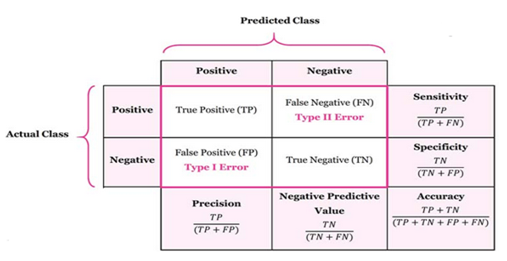

In [ ]:
y_prediction = model.predict([test_inp,test_mask])
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=test_label
#Create confusion matrix and normalizes it over predicted (columns)
target_names = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
result = classification_report(y_test, y_prediction,target_names=target_names, digits=4)
print(result)

94/94 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

     sadness     0.9635    0.9646    0.9640       875
       anger     0.9363    0.9217    0.9289       383
        love     0.8631    0.9228    0.8919       246
    surprise     0.8846    0.7340    0.8023        94
        fear     0.8936    0.9385    0.9155       358
         joy     0.9677    0.9547    0.9612      1037

    accuracy                         0.9419      2993
   macro avg     0.9182    0.9060    0.9107      2993
weighted avg     0.9424    0.9419    0.9417      2993



<img src='https://miro.medium.com/v2/resize:fit:507/1*i4D7Bb5SKjgaoFPxTC6pLA.png'>

1d. untuk penjelasan precistion, recall, dan accuracy dapat dilihat di gambar atas, untuk kasus ini kita mendapatkan akurasi di angka 0.9419. Tetapi karena data Y kita tidak balance dapat dilihat di countplot atas, maka kita dapat melihat f-1 score dari setiap kategori. f1 score menunjukan seberapa baik model tersebut dalam memprediksi kelas tertentu. dapat dilihat bahwa f1-socre rata-ratanya diatas 90% dan yang terkecil ada di surprise di angka 80%, hal ini bisa disebabkan karena data surprise yang sedikit sehingga kurangnya bahan untuk model pelajari. untuk precision sudah cukup bagus karena nilai terkecilnya hanya 0.8631 pada surprise, sayangnya recall surprise sangat rendah jika dibandingkan kategori lainnya. hal inilah yang menyebabkan mengapa f-1 score surprise bisa lebih rendah dari yang lainnya. kesimpulannya model ini sudah sangat baik dalam melakukan emotion classification, hanya saja masih kurang dalam meprediksi emosi surprise.